In [1]:
from google.colab import output

#데이터

##테이터 받아오기

Opinet : https://www.opinet.co.kr/user/dopospdrg/dopOsPdrgAreaSelect.do<br>

전체 주유소의 제품별 평균 판매가격(부가세포함)<br>
-> 제품 : 일반 휘발유, 기간 : 2016.01.01 ~ 2023.11.30, 측정 주기: 일간 평균(소수점 2자리)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (10,7)
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("gasprice.csv")
print(df.iloc[2400:2401,:])
df = df.iloc[:,1:2]
df.columns

             date    price
2400  2022년07월28일  1916.88


Index(['price'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2891 non-null   float64
dtypes: float64(1)
memory usage: 22.7 KB


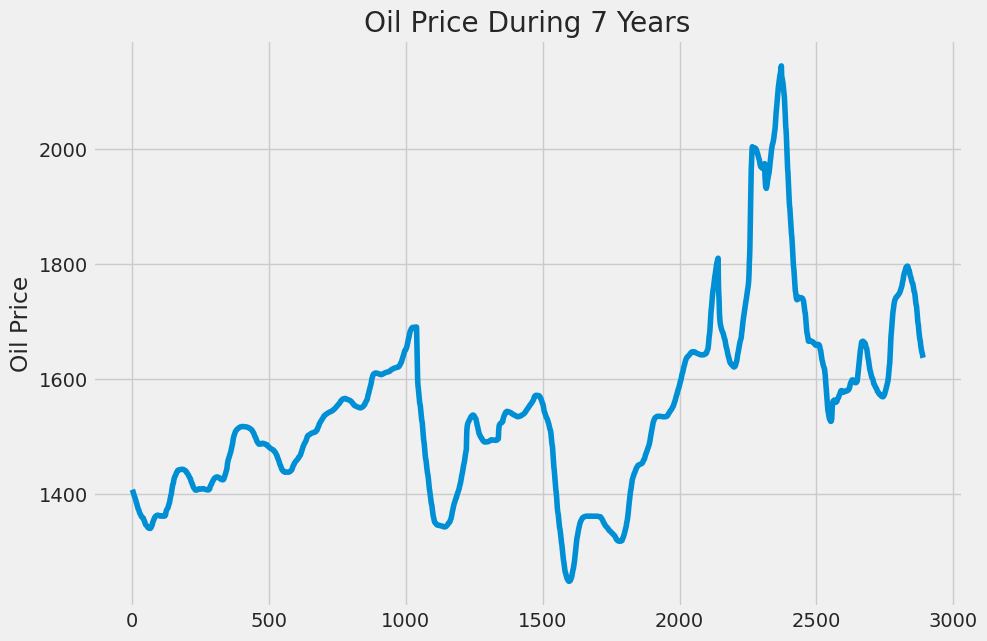

In [ ]:
df['price'].plot()
plt.ylabel('Oil Price')
plt.xlabel(None)
plt.title(f"Oil Price During 7 Years")

plt.show()

#normalization 없이 돌리기

##노말라이제이션 없는 test, train split

전체 : train : test = 85 : 15 (대략) <br>
   --> train : 2016.1.1 ~ 2022.7.27 <br>
   --> test : 2022.7.28 ~ 2023.11.30


학습: train : 5일치, test : 2일

In [6]:
def ts_train_test(all_data,time_steps,for_periods):

    # create training and test set
    ts_train = all_data[:2400].iloc[:,0:1].values
    ts_test  = all_data[2400:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1):
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["price"][:2400], all_data["price"][2400:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(df,5,2)
X_train.shape[0],X_train.shape[1]

(2394, 5)

학습 데이터

In [7]:
# Make the 3-D shape to a data frame so we can see:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,1407.15,1405.98,1405.33,1403.84,1402.25,1400.78,1399.15
1,1405.98,1405.33,1403.84,1402.25,1400.78,1399.15,1397.36
2,1405.33,1403.84,1402.25,1400.78,1399.15,1397.36,1395.62
3,1403.84,1402.25,1400.78,1399.15,1397.36,1395.62,1394.79
4,1402.25,1400.78,1399.15,1397.36,1395.62,1394.79,1393.53
...,...,...,...,...,...,...,...
2389,2034.36,2026.25,2013.01,2002.16,1989.93,1977.25,1964.60
2390,2026.25,2013.01,2002.16,1989.93,1977.25,1964.60,1959.42
2391,2013.01,2002.16,1989.93,1977.25,1964.60,1959.42,1948.86
2392,2002.16,1989.93,1977.25,1964.60,1959.42,1948.86,1936.63


테스트 데이터

In [8]:
# Make the 3-D shape to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))

pd.DataFrame(X_test_see)

,0,1,2,3,4
0,1964.60,1959.42,1948.86,1936.63,1926.81
1,1959.42,1948.86,1936.63,1926.81,1916.88
2,1948.86,1936.63,1926.81,1916.88,1907.31
3,1936.63,1926.81,1916.88,1907.31,1900.44
4,1926.81,1916.88,1907.31,1900.44,1897.27
...,...,...,...,...,...
484,1667.51,1664.78,1659.12,1656.54,1652.96
485,1664.78,1659.12,1656.54,1652.96,1649.56
486,1659.12,1656.54,1652.96,1649.56,1647.05
487,1656.54,1652.96,1649.56,1647.05,1645.97


In [ ]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2394 samples in the training data
There are 489 samples in the test data


## simple RNN model

In [ ]:
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

16/16 [==============================] - 0s 4ms/step


array([[57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ],
       [57.572845, 57.27129 ]], dtype=float32)

In [ ]:
my_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 32)             1088      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 3234 (12.63 KB)
Trainable params: 3234 (12.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['price', 'prediction'])
    actual_pred['price'] = df.iloc[2400:].loc[:,'price'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['price']),np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot() )

(2573983.0, <Axes: >)

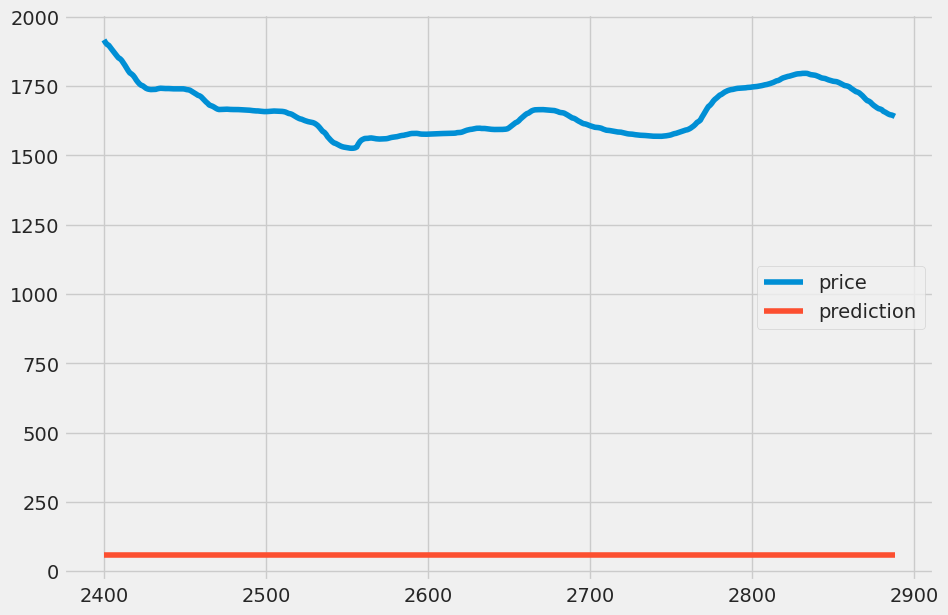

In [ ]:
actual_pred_plot(rnn_predictions)

# 노말라이제이션 후 simple RNN

normalization : min-max scaling (0,1)

In [4]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input:
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:2400].iloc[:,0:1].values
    ts_test  = all_data[2400:].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["price"][:2400], all_data["price"][2400:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def getRMSE(preds):
    rmse = np.sqrt(np.mean(((preds[:,0] - df.iloc[2400:2889].loc[:,'price']) ** 2)))
    print("RMSE: ", rmse)

def predFuture(model):
    start = X_test[-1:]
    preds = []
    input = start
    for i in range(14):
        next = ((model.predict(input,verbose=0)))
        preds.append(sc.inverse_transform(next));
        input = np.delete(input, 0)
        input = np.append(input, next[0][0])
        input = input.reshape(1,5,1)
    res = np.concatenate(preds)

    actual_pred = pd.DataFrame(columns = ['prediction'])
    actual_pred['prediction'] = res[:,0]
    actual_pred.plot()

In [5]:
def simple_rnn_model_normalization(X_train, y_train, X_test, sc, epochs):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=epochs, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

####에포크 1

16/16 [==============================] - 0s 3ms/step
RMSE:  74.5512935229381


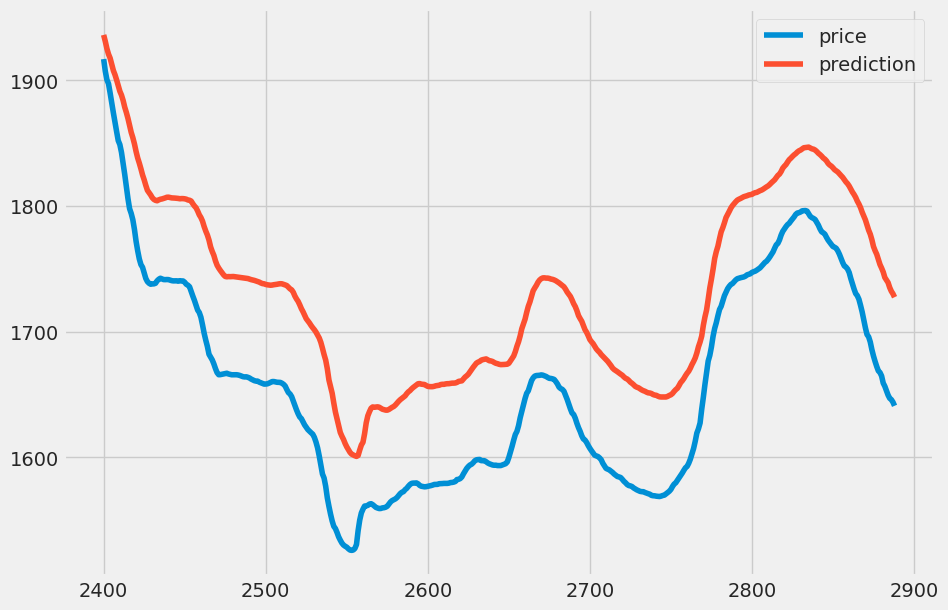

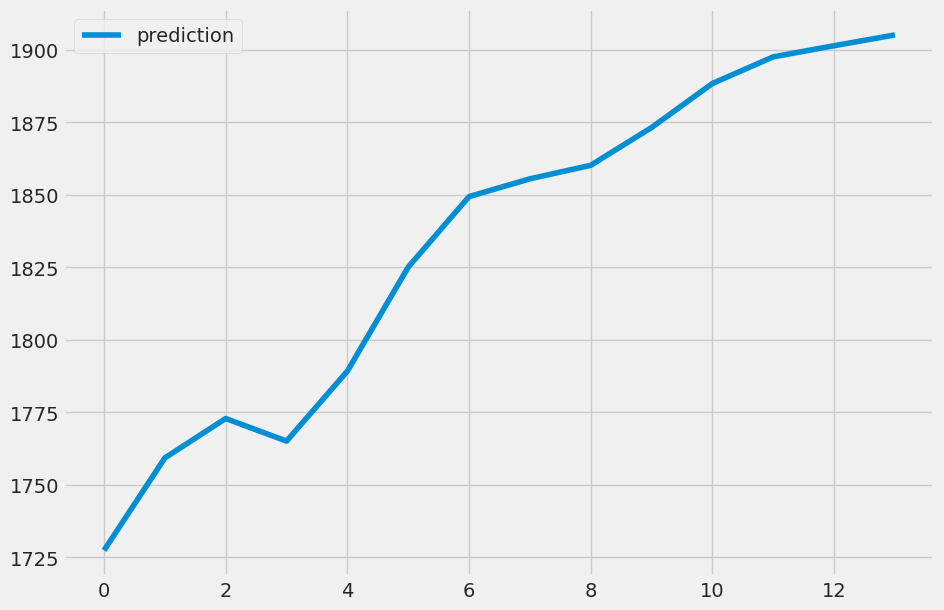

In [16]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_rnn_model_1, rnn_predictions_1 = simple_rnn_model_normalization(X_train, y_train, X_test, sc, 1)
rnn_predictions_1[1:10]
actual_pred_plot(rnn_predictions_1)
getRMSE(rnn_predictions_1)
predFuture(my_rnn_model_1)

####에포크 5

16/16 [==============================] - 0s 4ms/step
RMSE:  36.4058159739604


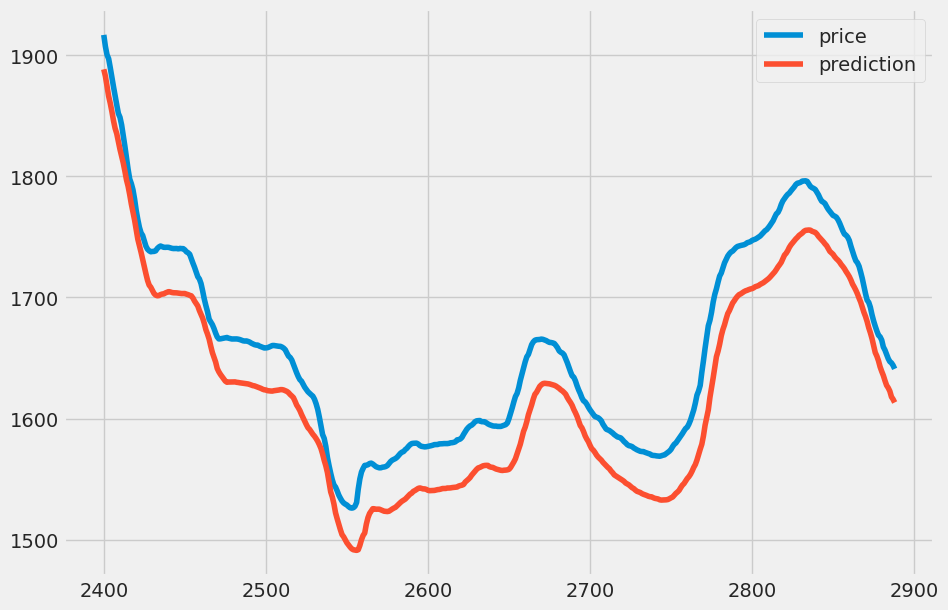

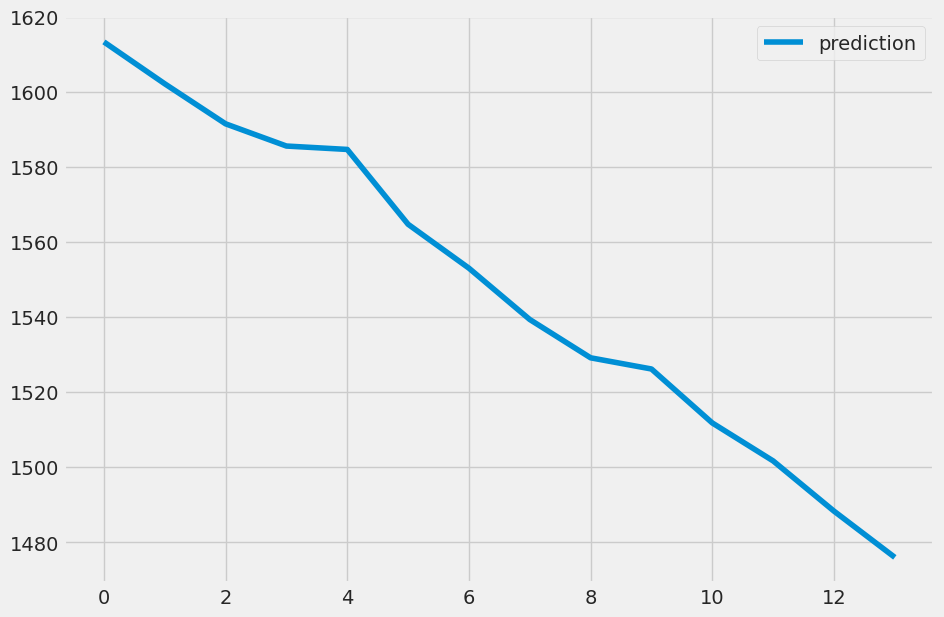

In [20]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_rnn_model_5, rnn_predictions_5 = simple_rnn_model_normalization(X_train, y_train, X_test, sc, 5)
rnn_predictions_5[1:10]
actual_pred_plot(rnn_predictions_5)
getRMSE(rnn_predictions_5)
predFuture(my_rnn_model_5)

####에포크 10

16/16 [==============================] - 0s 2ms/step
RMSE:  33.79723004599749


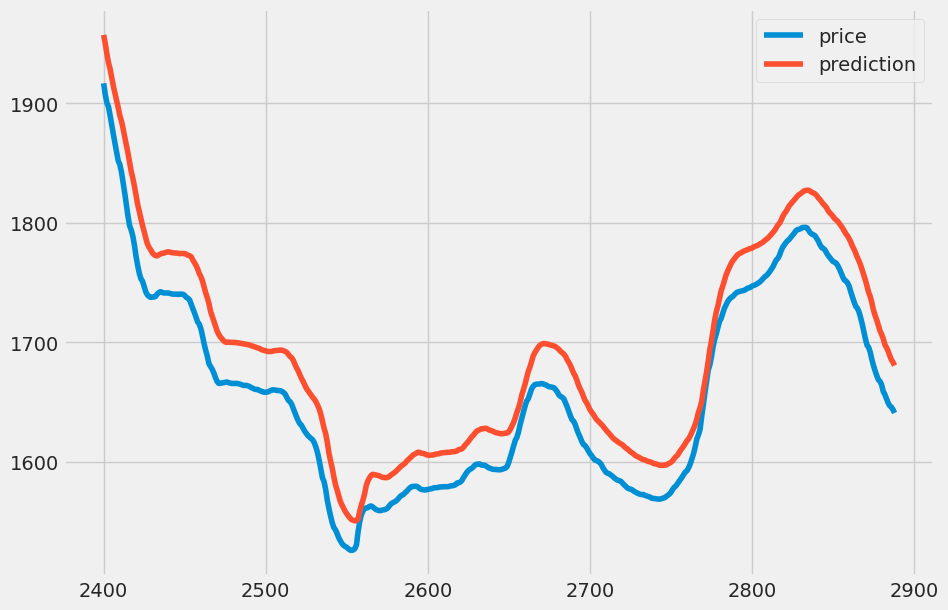

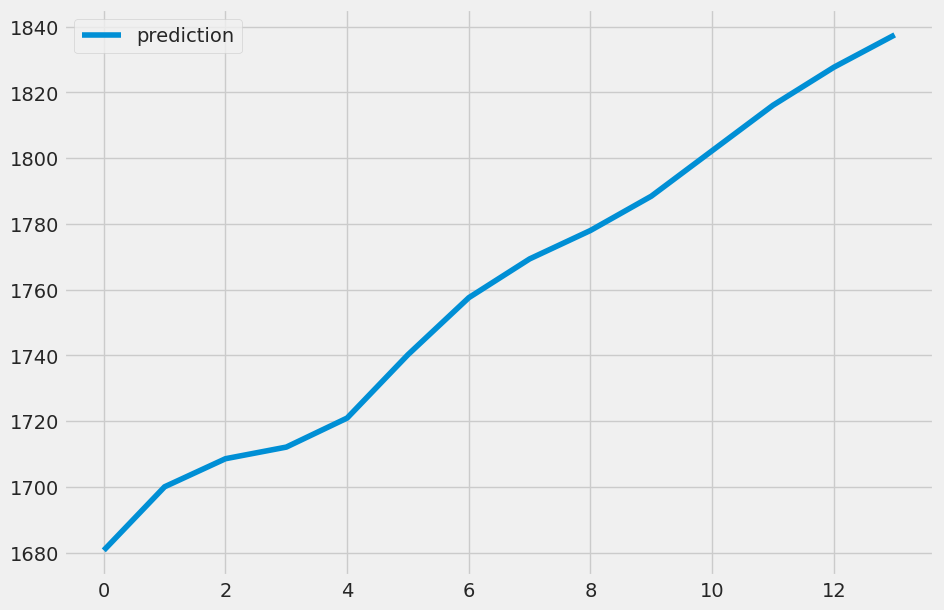

In [14]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_rnn_model_10, rnn_predictions_10 = simple_rnn_model_normalization(X_train, y_train, X_test, sc, 10)
rnn_predictions_10[1:10]
actual_pred_plot(rnn_predictions_10)
getRMSE(rnn_predictions_10)
predFuture(my_rnn_model_10)

####에포크 50

16/16 [==============================] - 0s 3ms/step
RMSE:  22.266472496177794


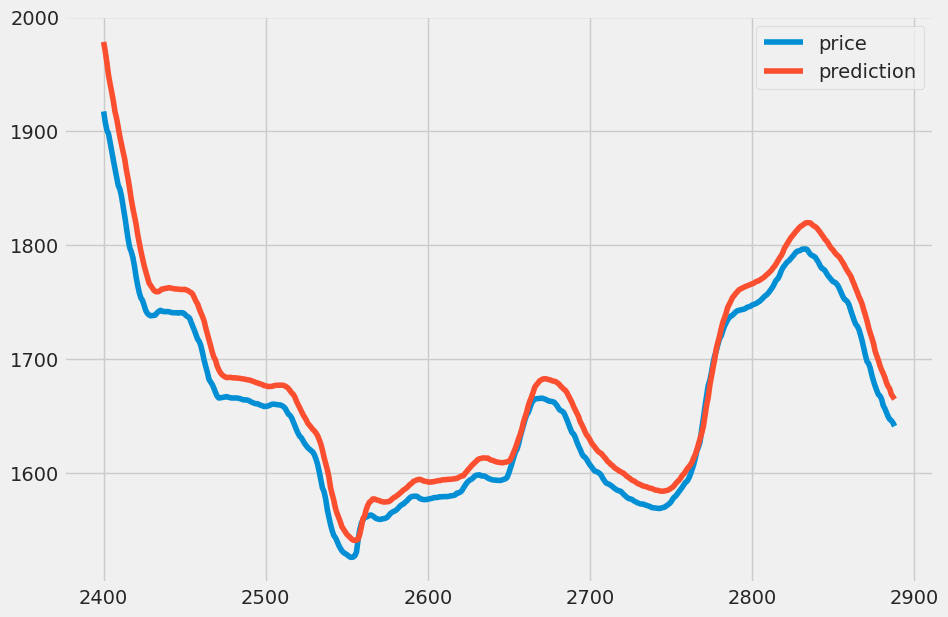

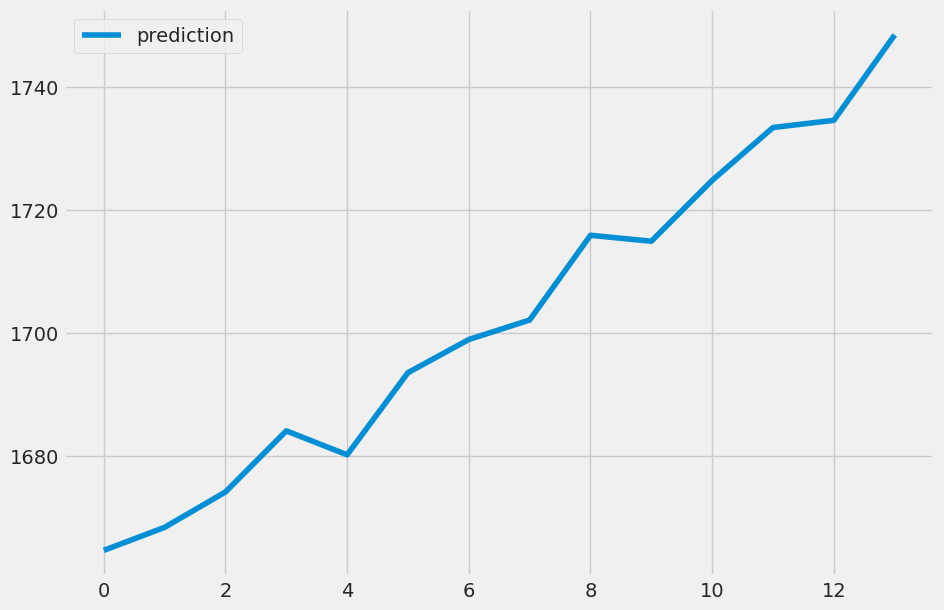

In [15]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_rnn_model_50, rnn_predictions_50 = simple_rnn_model_normalization(X_train, y_train, X_test, sc, 50)
rnn_predictions_50[1:10]
actual_pred_plot(rnn_predictions_50)
getRMSE(rnn_predictions_50)
predFuture(my_rnn_model_50)

In [ ]:
my_rnn_model_50.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 5, 32)             1088      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3234 (12.63 KB)
Trainable params: 3234 (12.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 노말라이제이션 후 LSTM

##LSTM

In [21]:
def LSTM_model(X_train, y_train, X_test, sc, epochs):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers.legacy import SGD

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=32, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop',loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=epochs,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

####에포크 1

16/16 [==============================] - 1s 2ms/step
RMSE:  178.43728600091208


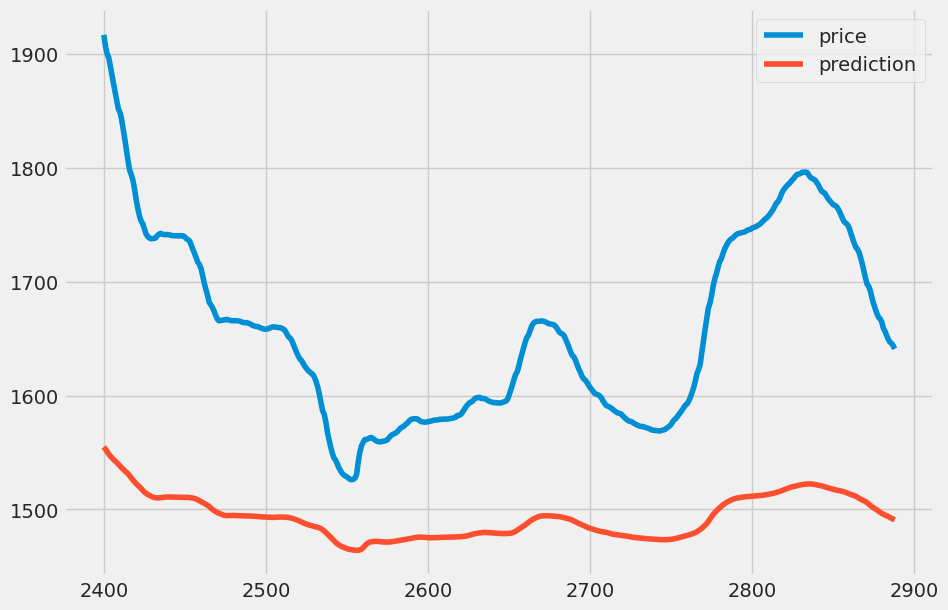

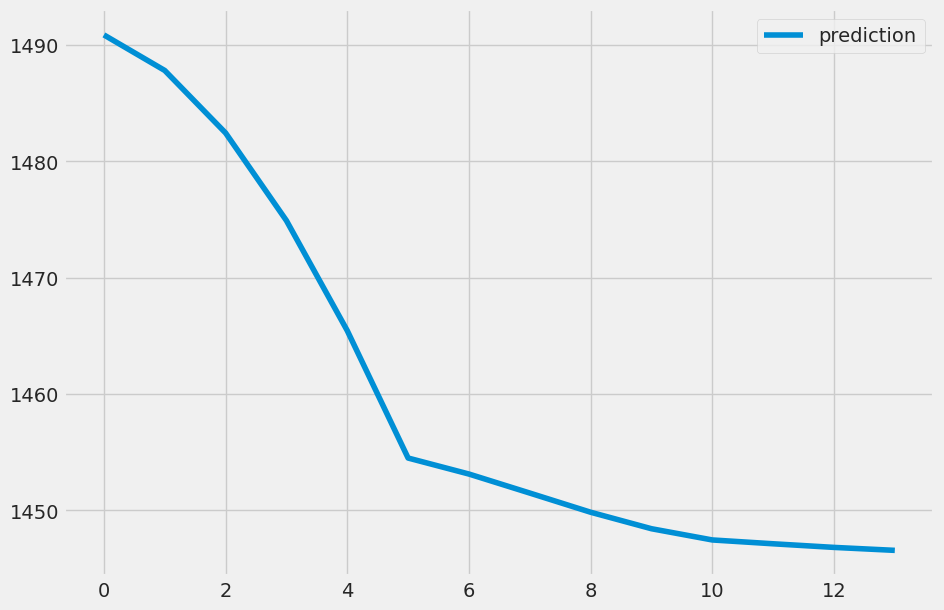

In [22]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_LSTM_model_1, LSTM_prediction_1 = LSTM_model(X_train, y_train, X_test, sc, 1)
LSTM_prediction_1[1:10]
actual_pred_plot(LSTM_prediction_1)
getRMSE(LSTM_prediction_1)
predFuture(my_LSTM_model_1)

####에포크 5

16/16 [==============================] - 1s 3ms/step
RMSE:  27.037566743183987


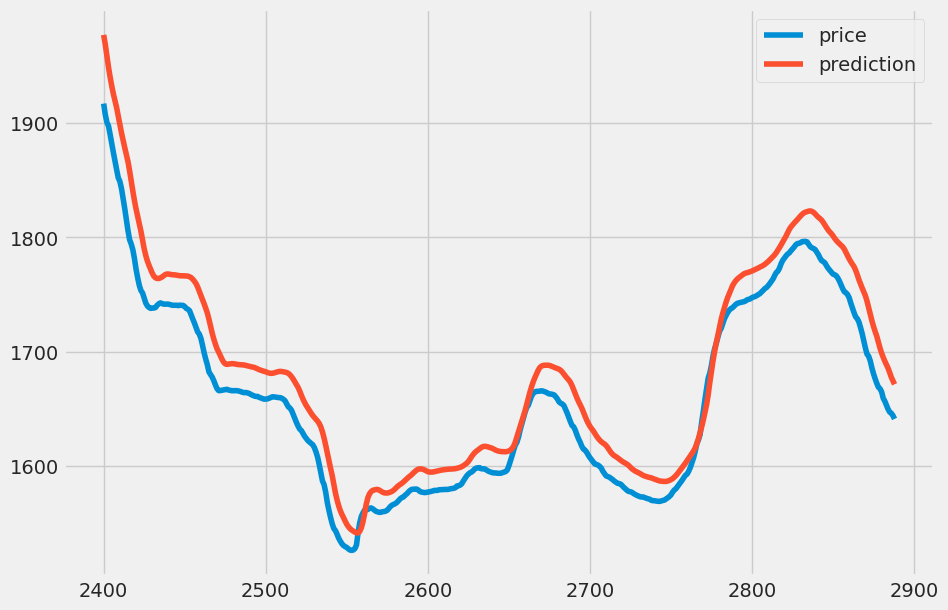

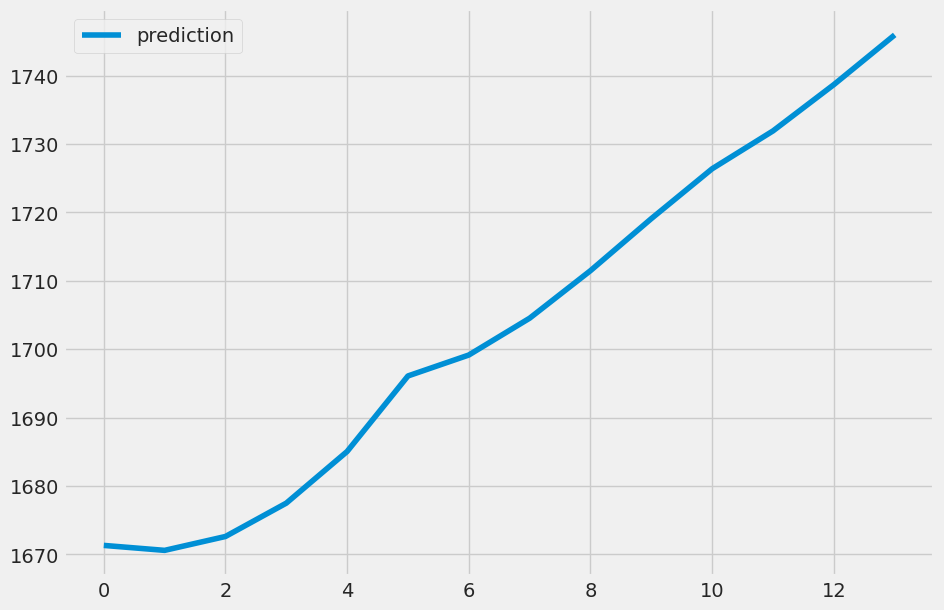

In [43]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_LSTM_model_5, LSTM_prediction_5 = LSTM_model(X_train, y_train, X_test, sc, 5)
LSTM_prediction_5[1:10]
actual_pred_plot(LSTM_prediction_5)
getRMSE(LSTM_prediction_5)
predFuture(my_LSTM_model_5)

####에포크 10

16/16 [==============================] - 1s 4ms/step
RMSE:  19.463507422391295


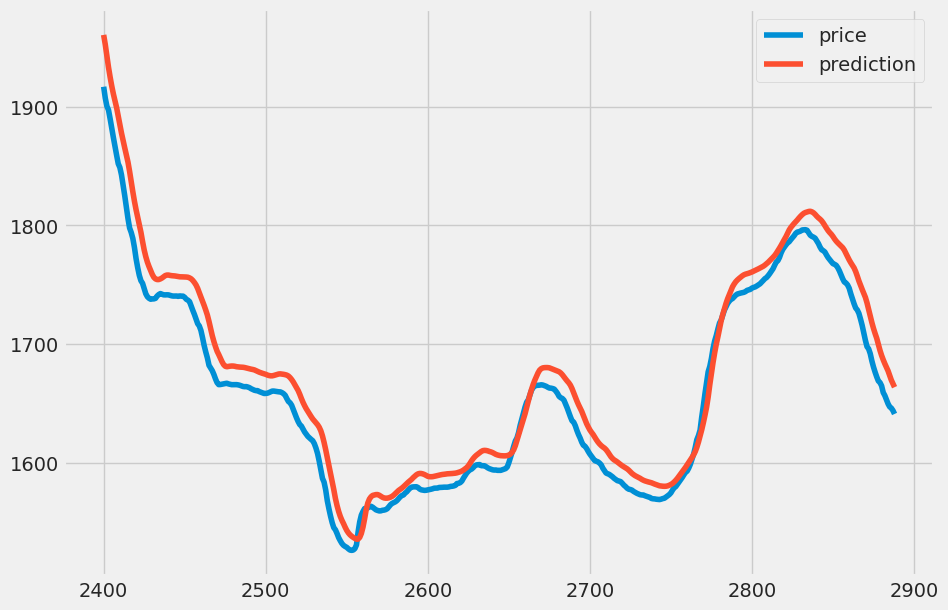

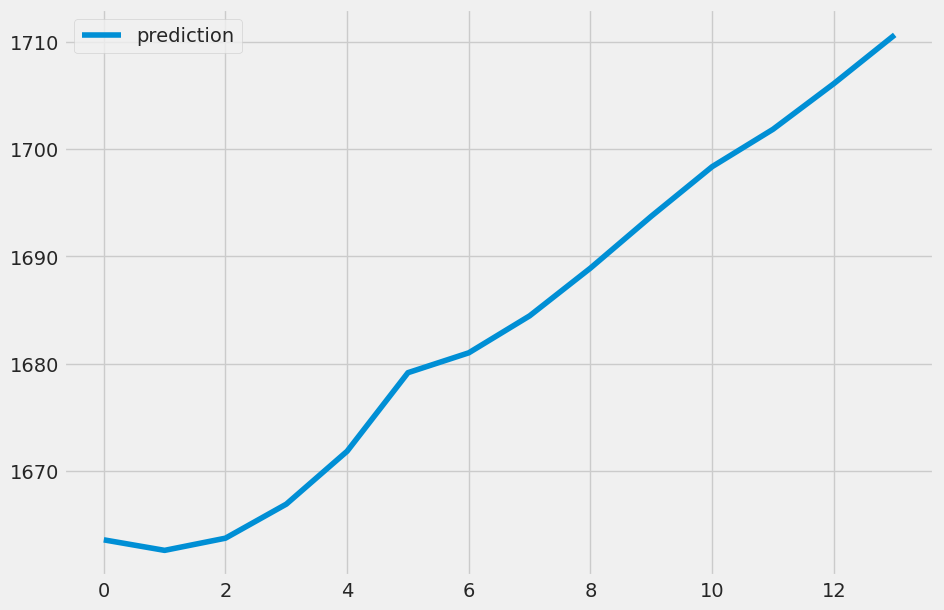

In [41]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_LSTM_model_10, LSTM_prediction_10 = LSTM_model(X_train, y_train, X_test, sc, 10)
LSTM_prediction_10[1:10]
actual_pred_plot(LSTM_prediction_10)
getRMSE(LSTM_prediction_10)
predFuture(my_LSTM_model_10)

####에포크 50

16/16 [==============================] - 1s 2ms/step
RMSE:  17.062587596953378


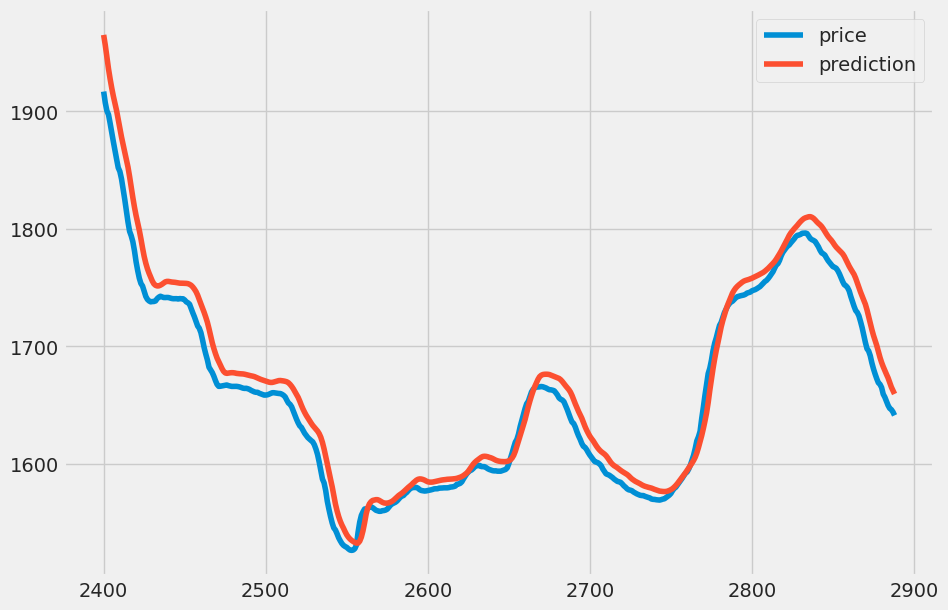

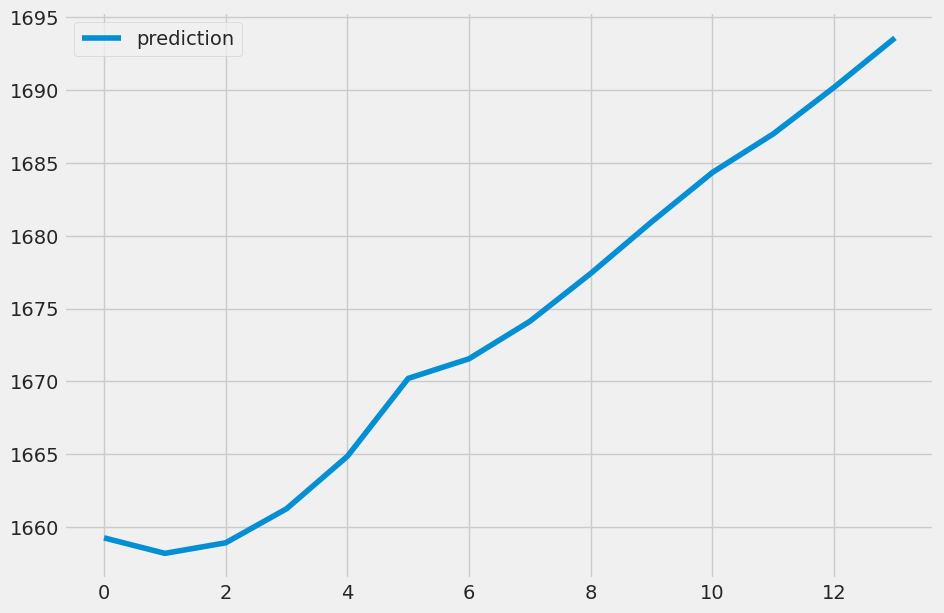

In [54]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_LSTM_model_50, LSTM_prediction_50 = LSTM_model(X_train, y_train, X_test, sc, 50)
LSTM_prediction_50[1:10]
actual_pred_plot(LSTM_prediction_50)
getRMSE(LSTM_prediction_50)
predFuture(my_LSTM_model_50)

In [ ]:
my_LSTM_model_50.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 32)             4352      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 12738 (49.76 KB)
Trainable params: 12738 (49.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## LSTM Regularization

In [29]:
def LSTM_model_regularization(X_train, y_train, X_test, sc, epoch):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from keras.optimizers.legacy import SGD

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=32, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop',loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=epoch,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

####에포크 1

16/16 [==============================] - 1s 2ms/step
RMSE:  136.2382702780119


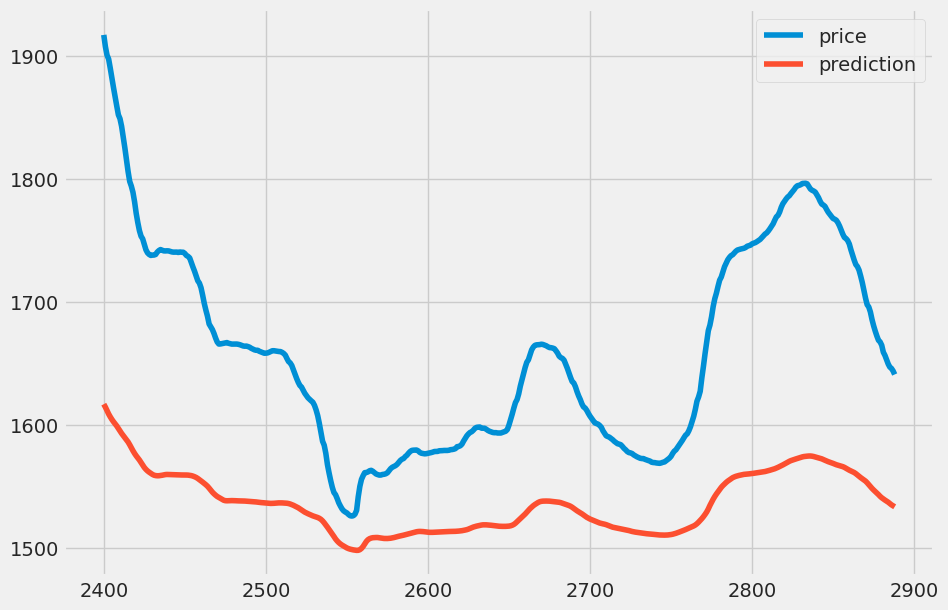

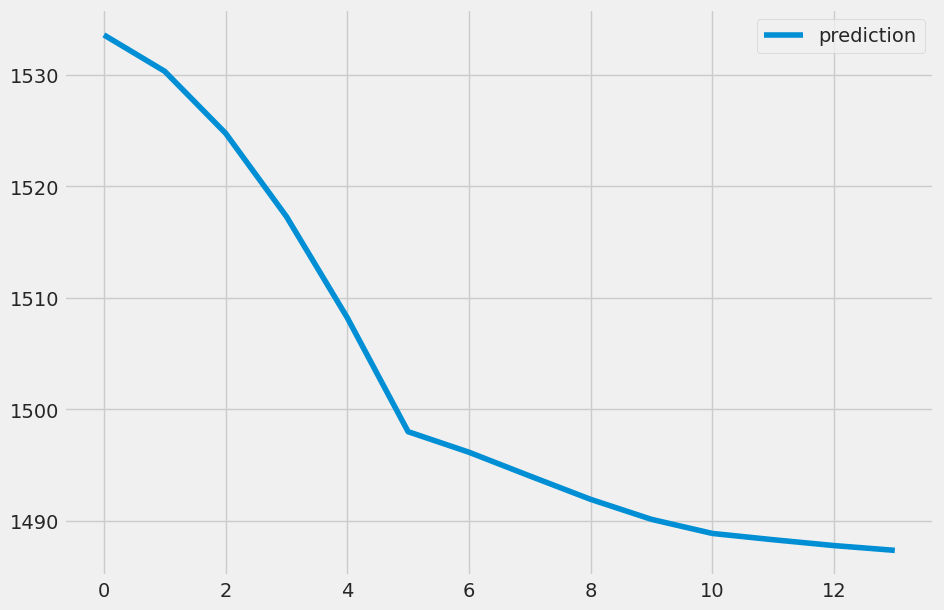

In [30]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_LSTM_model_1, R_LSTM_prediction_1 = LSTM_model_regularization(X_train, y_train, X_test, sc, 1)
R_LSTM_prediction_1[1:10]
actual_pred_plot(R_LSTM_prediction_1)
getRMSE(R_LSTM_prediction_1)
predFuture(my_R_LSTM_model_1)

####에포크 5

16/16 [==============================] - 1s 3ms/step
RMSE:  28.171478008430146


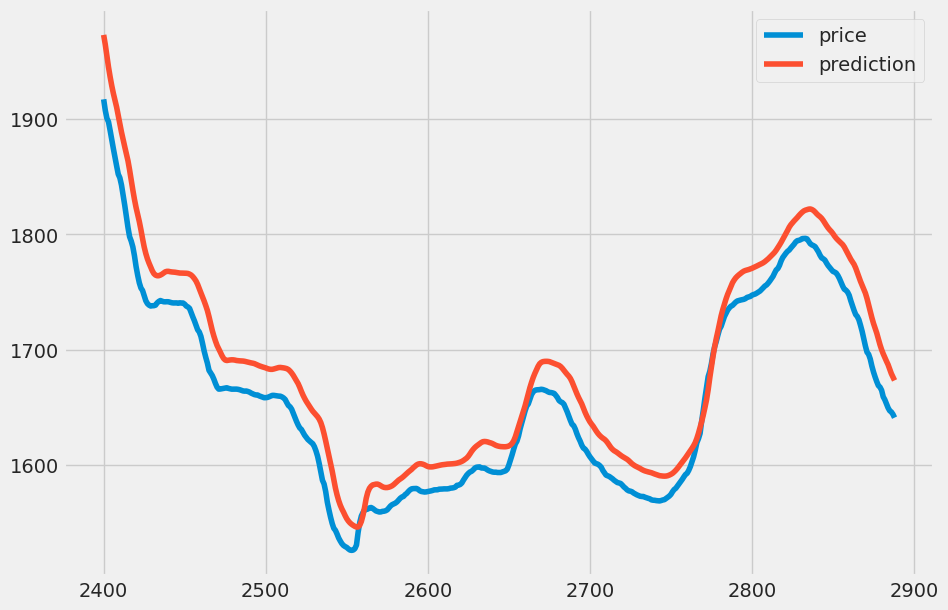

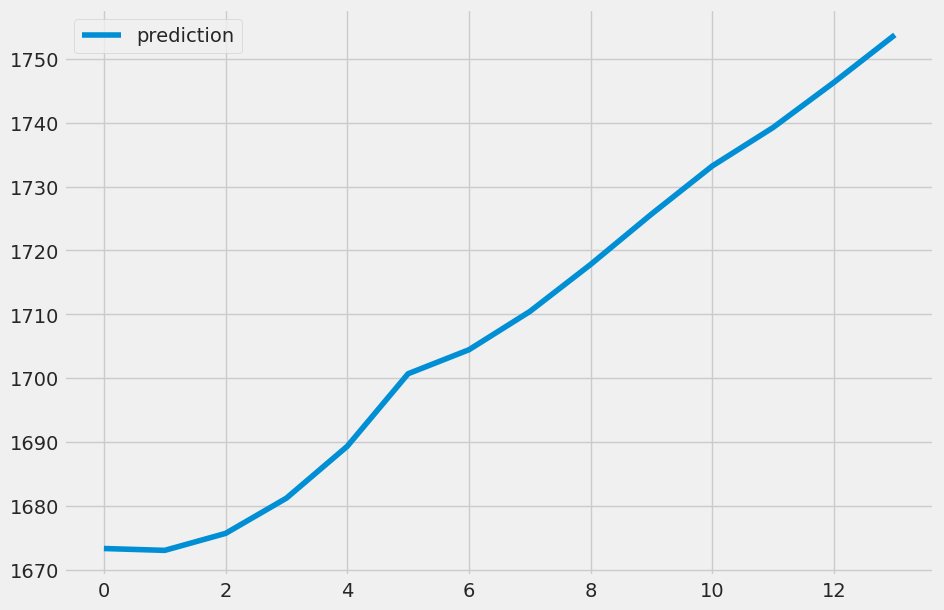

In [55]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_LSTM_model_5, R_LSTM_prediction_5 = LSTM_model_regularization(X_train, y_train, X_test, sc, 5)
R_LSTM_prediction_5[1:10]
actual_pred_plot(R_LSTM_prediction_5)
getRMSE(R_LSTM_prediction_5)
predFuture(my_R_LSTM_model_5)

####에포크 10

16/16 [==============================] - 1s 3ms/step
RMSE:  16.075862658410482


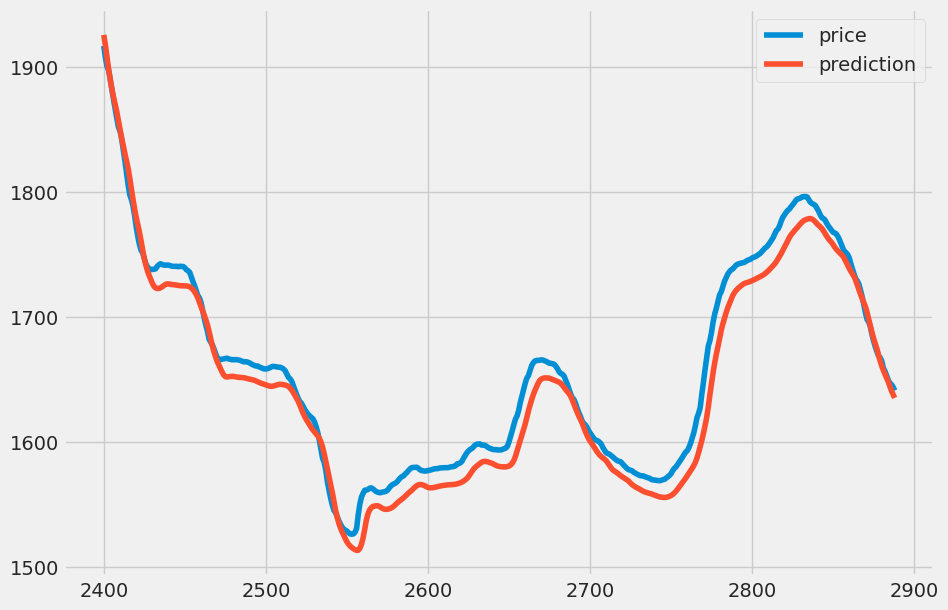

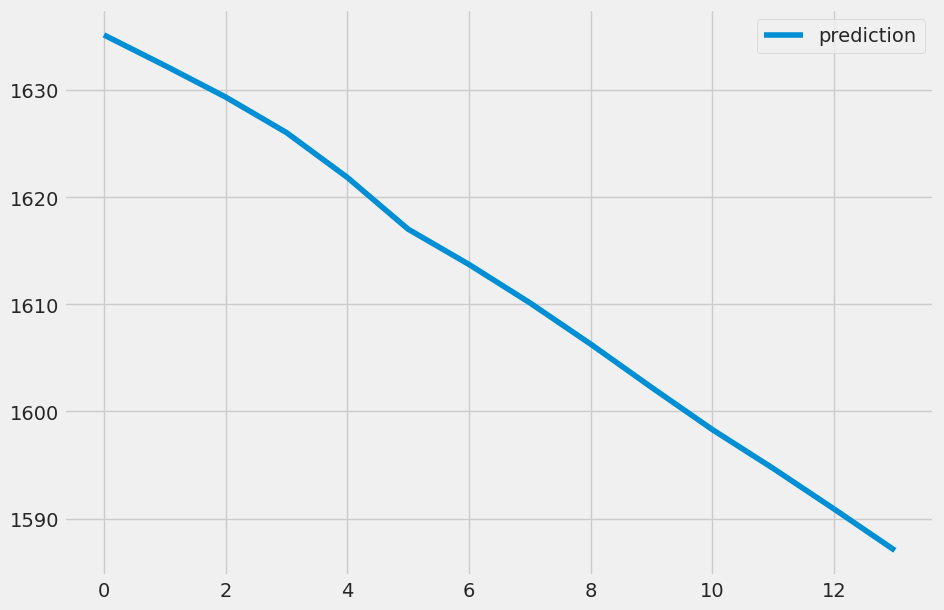

In [56]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_LSTM_model_10, R_LSTM_prediction_10 = LSTM_model_regularization(X_train, y_train, X_test, sc, 10)
R_LSTM_prediction_10[1:10]
actual_pred_plot(R_LSTM_prediction_10)
getRMSE(R_LSTM_prediction_10)
predFuture(my_R_LSTM_model_10)

####에포크 50

16/16 [==============================] - 1s 2ms/step
RMSE:  11.121208140208152


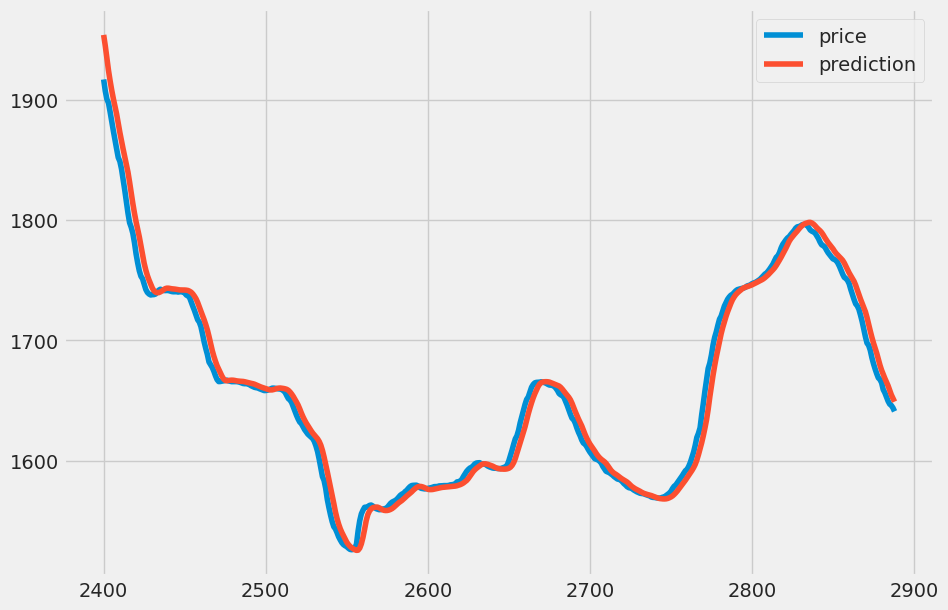

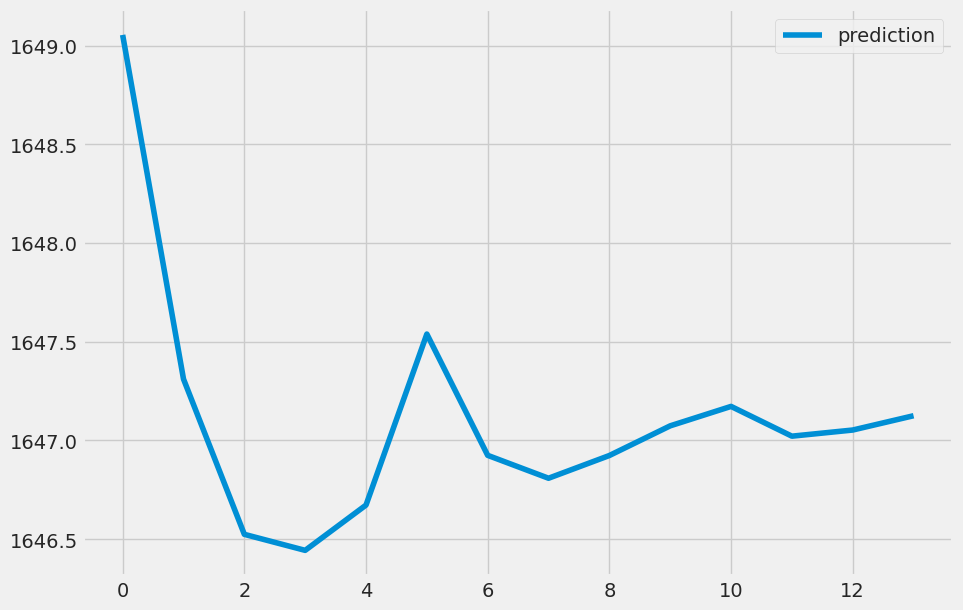

In [58]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_LSTM_model_50, R_LSTM_prediction_50 = LSTM_model_regularization(X_train, y_train, X_test, sc, 50)
R_LSTM_prediction_50[1:10]
actual_pred_plot(R_LSTM_prediction_50)
getRMSE(R_LSTM_prediction_50)
predFuture(my_R_LSTM_model_50)

In [ ]:
my_R_LSTM_model_50.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_15 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                                 
Total params: 12738 (49.76 KB)
Trainable params: 12738 (49.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 노말라이제이션 후 GRU



##GRU

In [44]:
def GRU_model(X_train, y_train, X_test, sc, epoch):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers.legacy import SGD

    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=32, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer='rmsprop',loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=epoch,batch_size=150, verbose=0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

####에포크 1

16/16 [==============================] - 1s 3ms/step
RMSE:  84.45133249772285


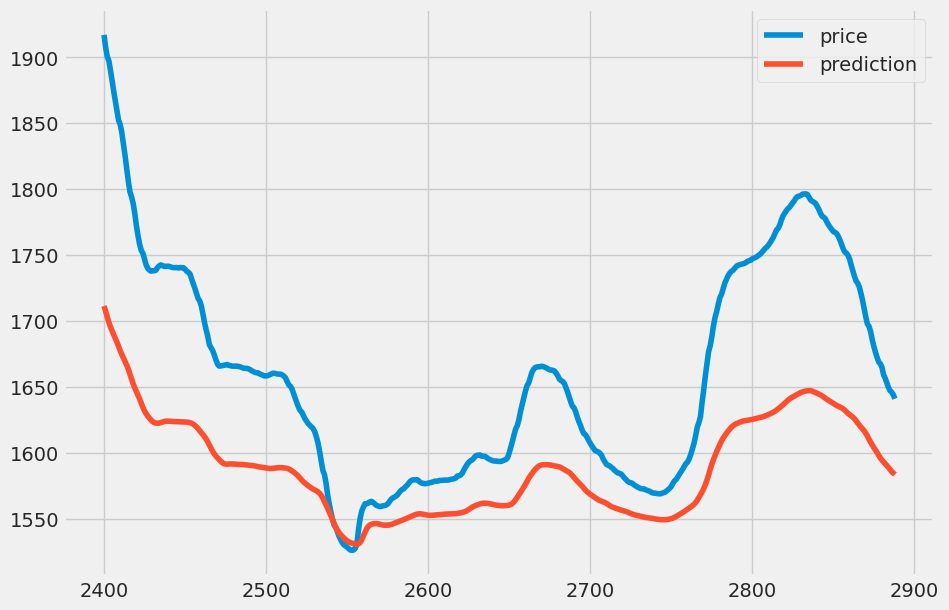

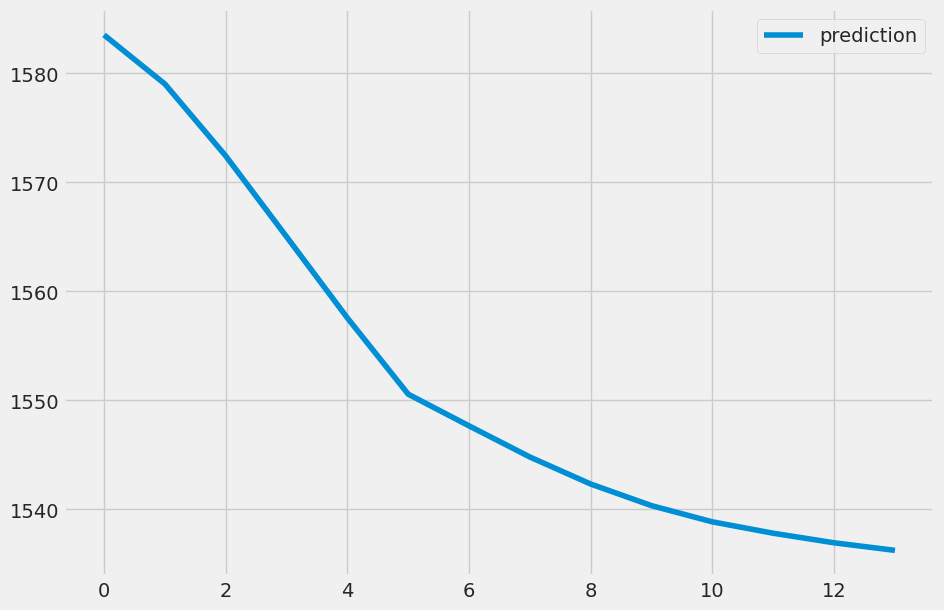

In [45]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_GRU_model_1, GRU_prediction_1 = GRU_model(X_train, y_train, X_test, sc, 1)
GRU_prediction_1[1:10]
actual_pred_plot(GRU_prediction_1)
getRMSE(GRU_prediction_1)
predFuture(my_GRU_model_1)

####에포크 5

16/16 [==============================] - 1s 2ms/step
RMSE:  29.647720490634818


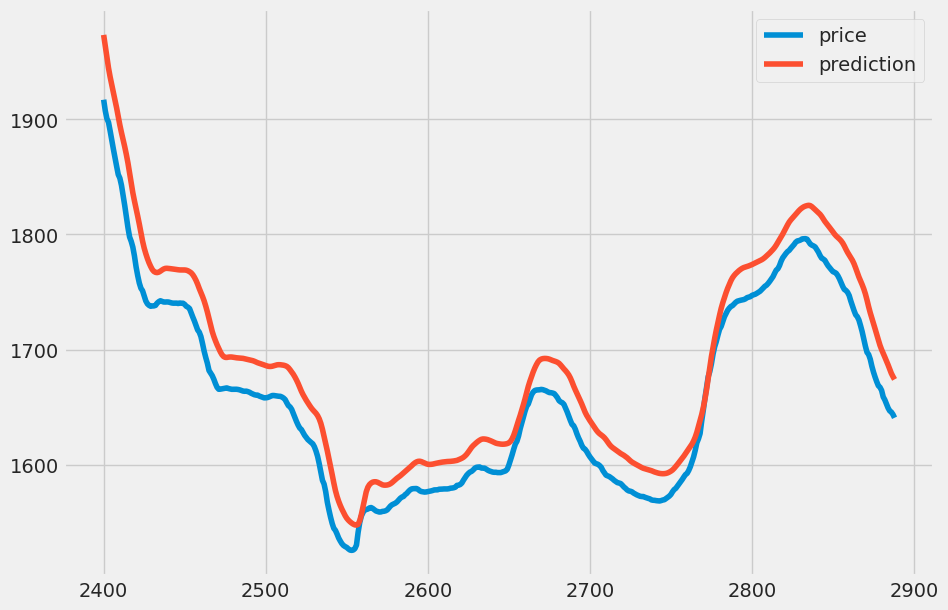

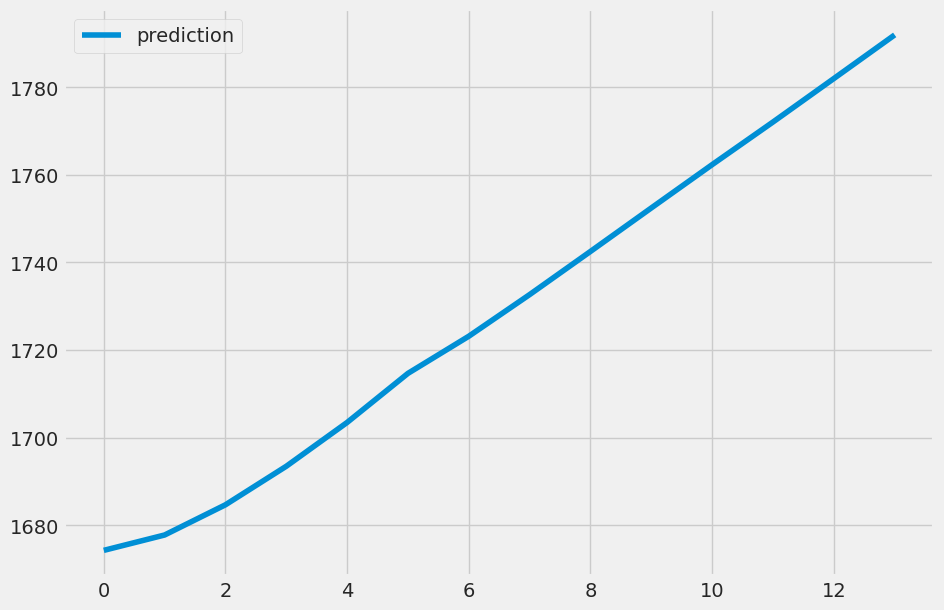

In [59]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_GRU_model_5, GRU_prediction_5 = GRU_model(X_train, y_train, X_test, sc, 5)
GRU_prediction_5[1:10]
actual_pred_plot(GRU_prediction_5)
getRMSE(GRU_prediction_5)
predFuture(my_GRU_model_5)

####에포크 10

16/16 [==============================] - 1s 4ms/step
RMSE:  28.169437174107912


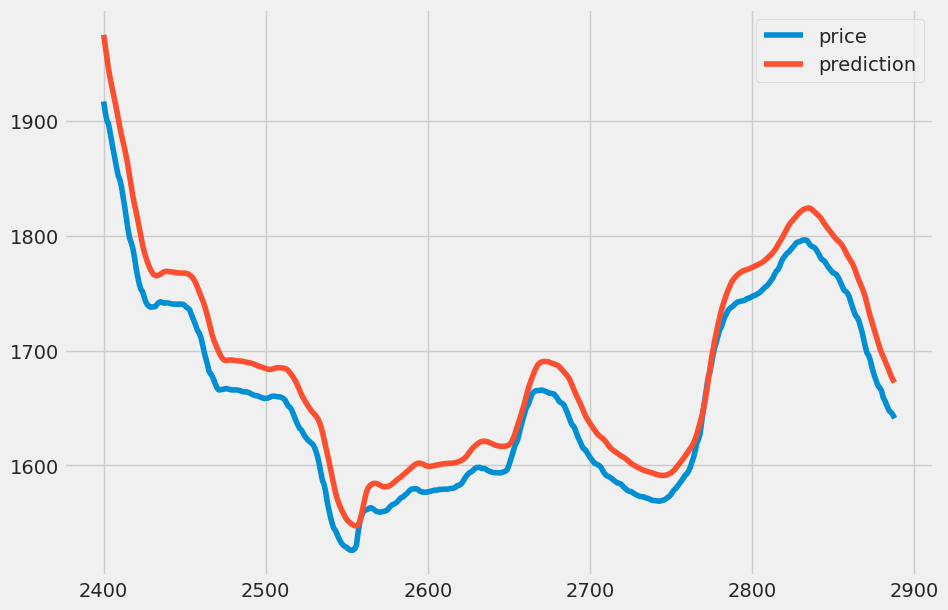

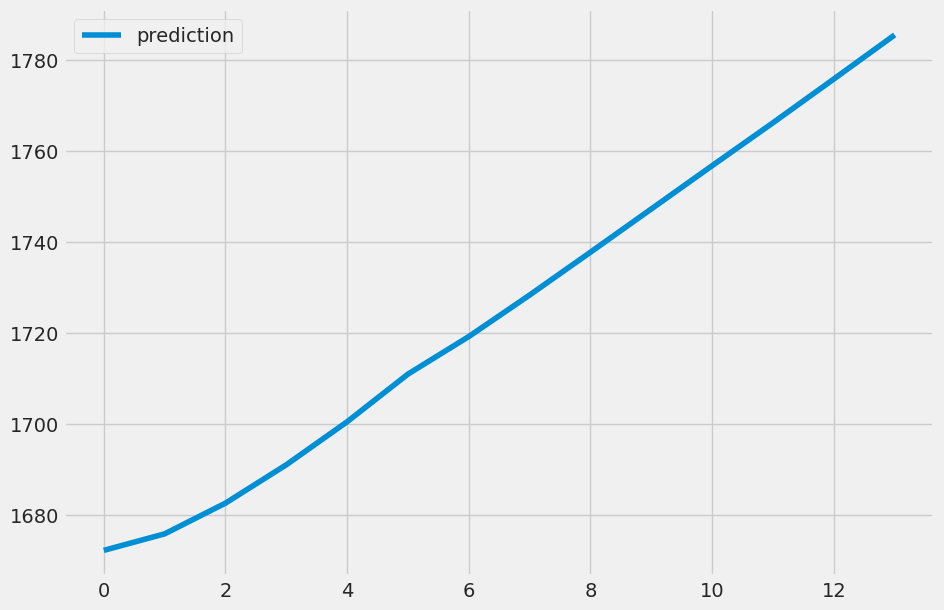

In [47]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_GRU_model_10, GRU_prediction_10 = GRU_model(X_train, y_train, X_test, sc, 10)
GRU_prediction_10[1:10]
actual_pred_plot(GRU_prediction_10)
getRMSE(GRU_prediction_10)
predFuture(my_GRU_model_10)

####에포크 50

16/16 [==============================] - 1s 2ms/step
RMSE:  20.085190201586553


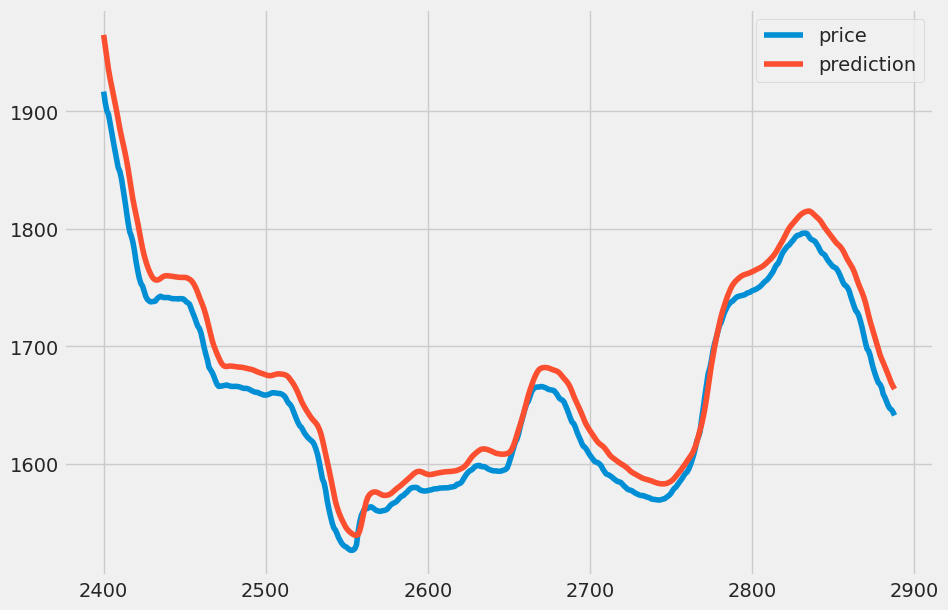

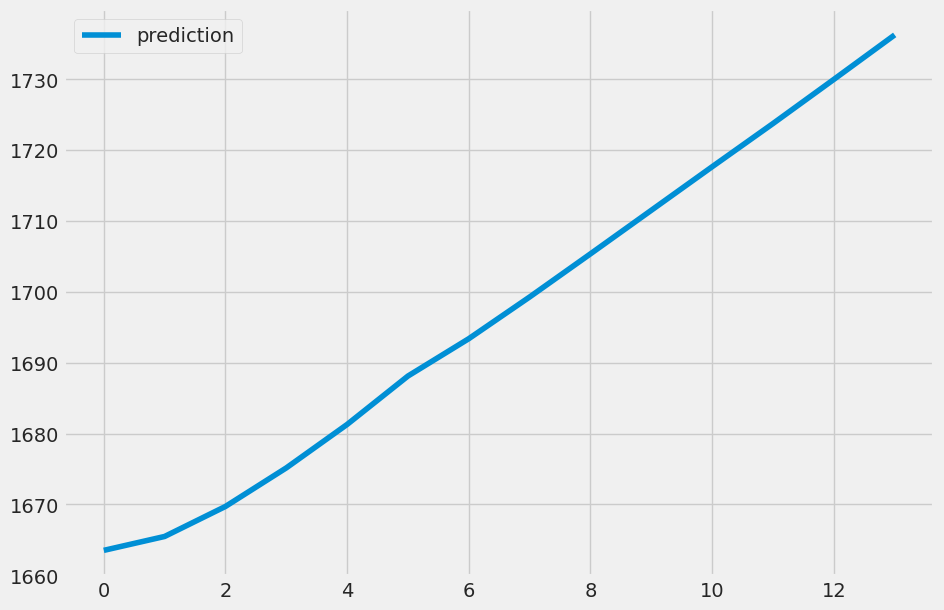

In [48]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_GRU_model_50, GRU_prediction_50 = GRU_model(X_train, y_train, X_test, sc, 50)
GRU_prediction_50[1:10]
actual_pred_plot(GRU_prediction_50)
getRMSE(GRU_prediction_50)
predFuture(my_GRU_model_50)

In [ ]:
my_GRU_model_50.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 32)             3360      
                                                                 
 gru_7 (GRU)                 (None, 32)                6336      
                                                                 
 dense_16 (Dense)            (None, 2)                 66        
                                                                 
Total params: 9762 (38.13 KB)
Trainable params: 9762 (38.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## GRU Regularization

In [49]:
def GRU_model_regularization(X_train, y_train, X_test, sc, epoch):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers.legacy import SGD
    from keras.layers import Dropout

    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=32, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))

    # Third GRU layer
    my_GRU_model.add(GRU(units=32, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=32, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=1))
    # Compiling the RNN
    my_GRU_model.compile(optimizer='rmsprop',loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=epoch,batch_size=150, verbose=0)

    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

####에포크 1

16/16 [==============================] - 1s 4ms/step
RMSE:  79.84851001260762


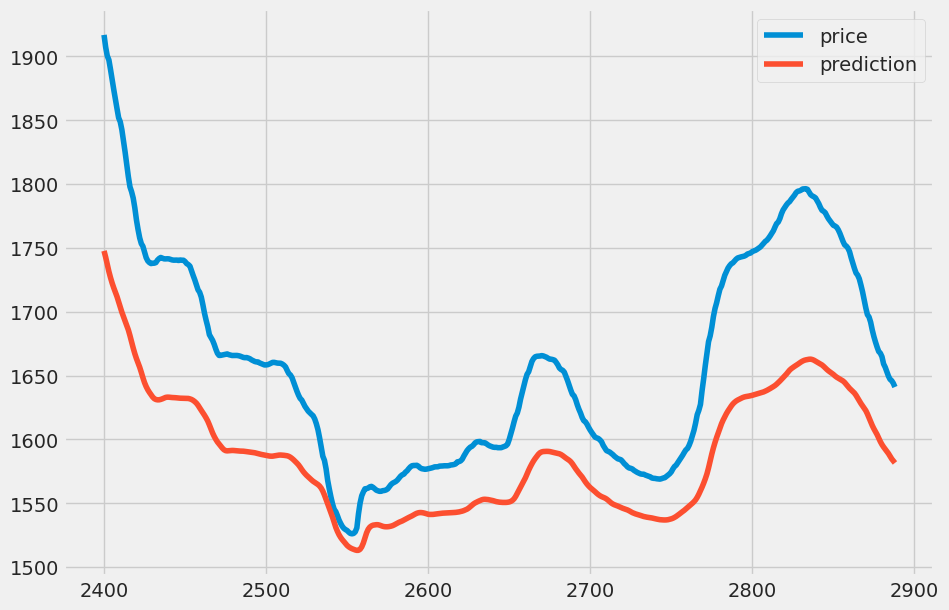

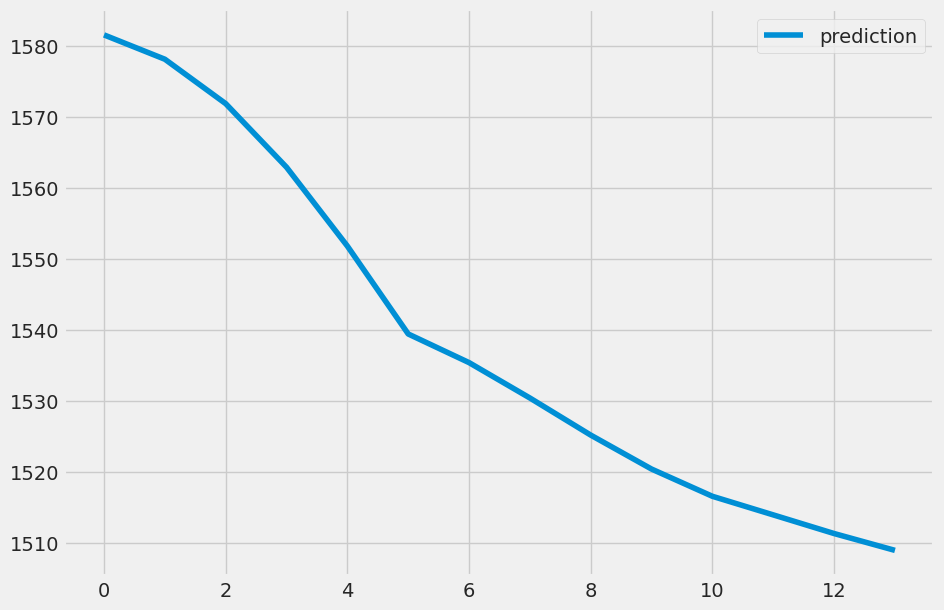

In [50]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_GRU_model_1, R_GRU_predictions_1 = GRU_model_regularization(X_train, y_train, X_test, sc, 1)
R_GRU_predictions_1[1:10]
actual_pred_plot(R_GRU_predictions_1)
getRMSE(R_GRU_predictions_1)
predFuture(my_R_GRU_model_1)

####에포크 5

16/16 [==============================] - 1s 3ms/step
RMSE:  24.737808741493907


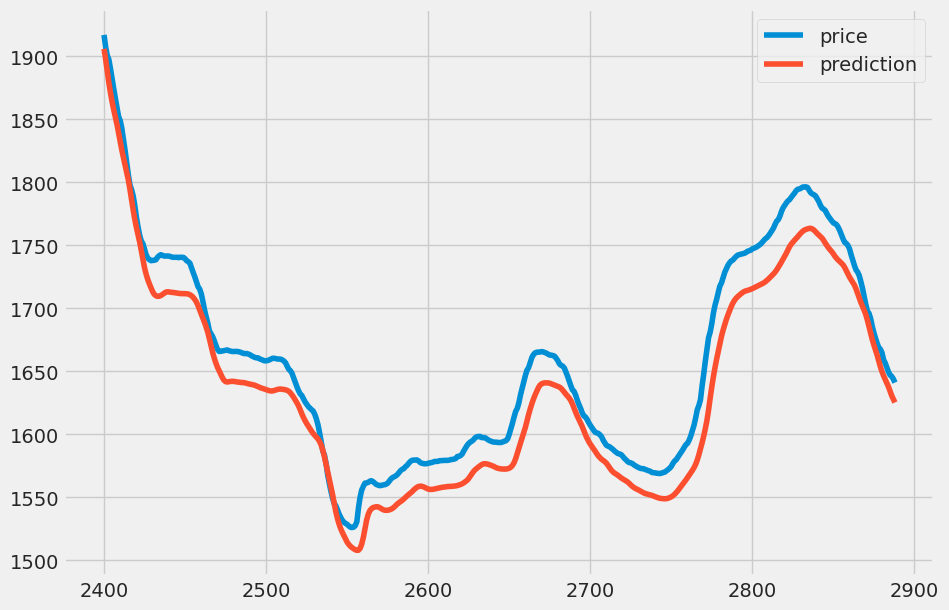

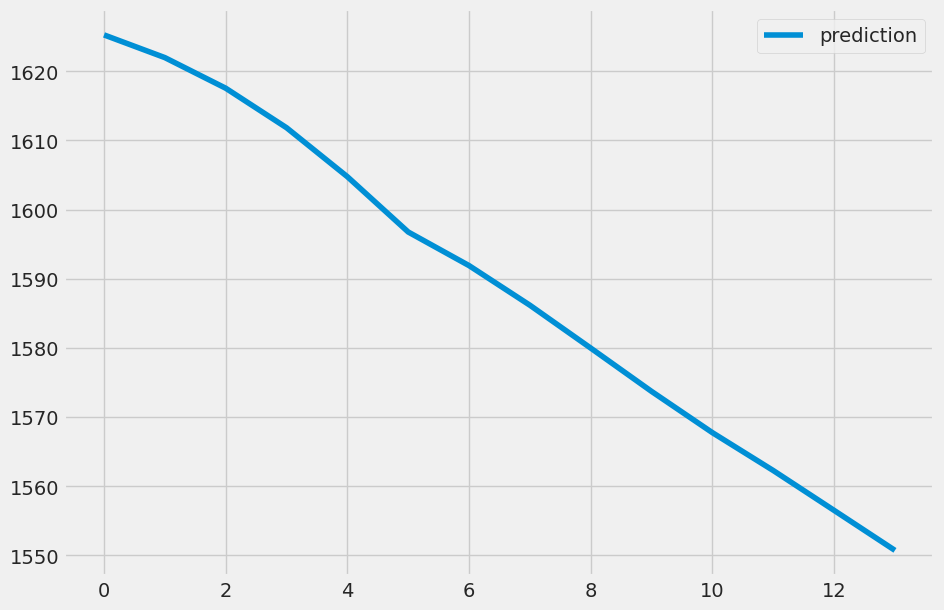

In [60]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_GRU_model_5, R_GRU_predictions_5 = GRU_model_regularization(X_train, y_train, X_test, sc, 5)
R_GRU_predictions_5[1:10]
actual_pred_plot(R_GRU_predictions_5)
getRMSE(R_GRU_predictions_5)
predFuture(my_R_GRU_model_5)

####에포크 10

16/16 [==============================] - 1s 3ms/step
RMSE:  11.501807375778307


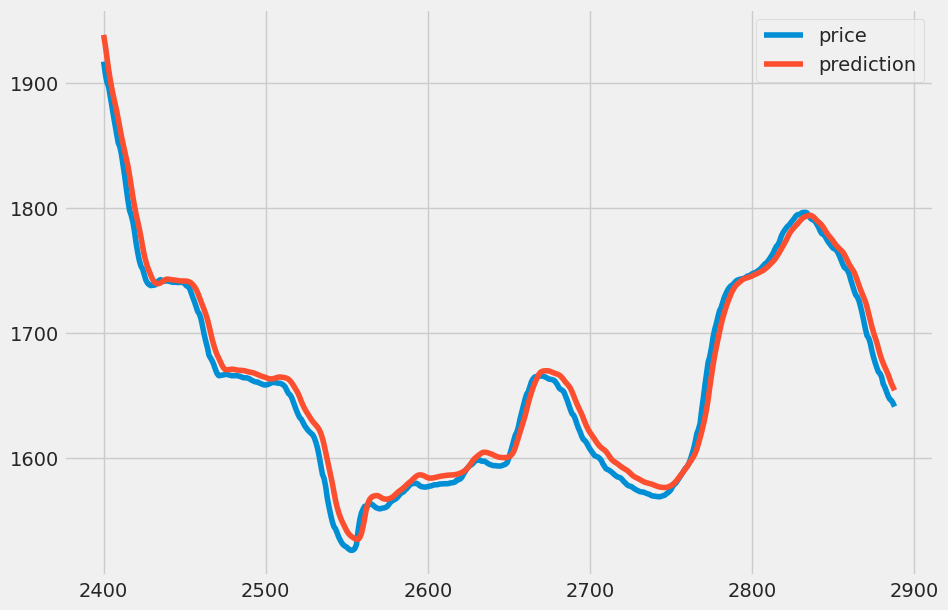

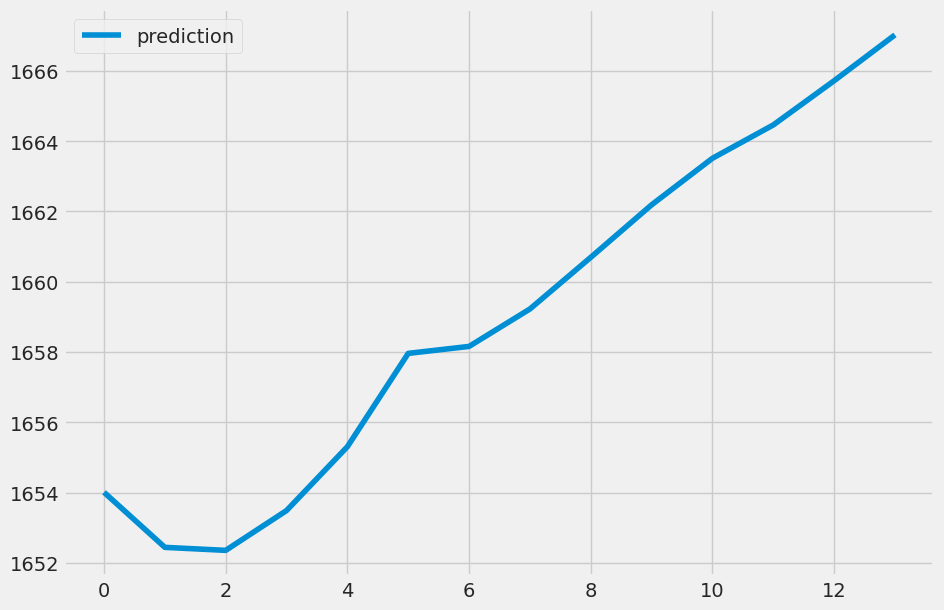

In [61]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_GRU_model_10, R_GRU_predictions_10 = GRU_model_regularization(X_train, y_train, X_test, sc, 10)
R_GRU_predictions_10[1:10]
actual_pred_plot(R_GRU_predictions_10)
getRMSE(R_GRU_predictions_10)
predFuture(my_R_GRU_model_10)

####에포크 50

16/16 [==============================] - 1s 3ms/step
RMSE:  10.78635695817664


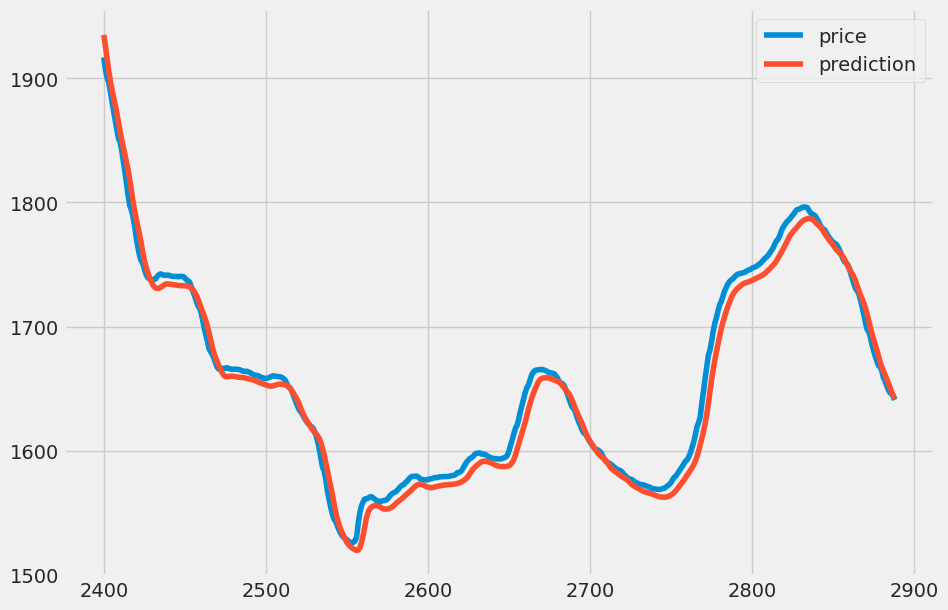

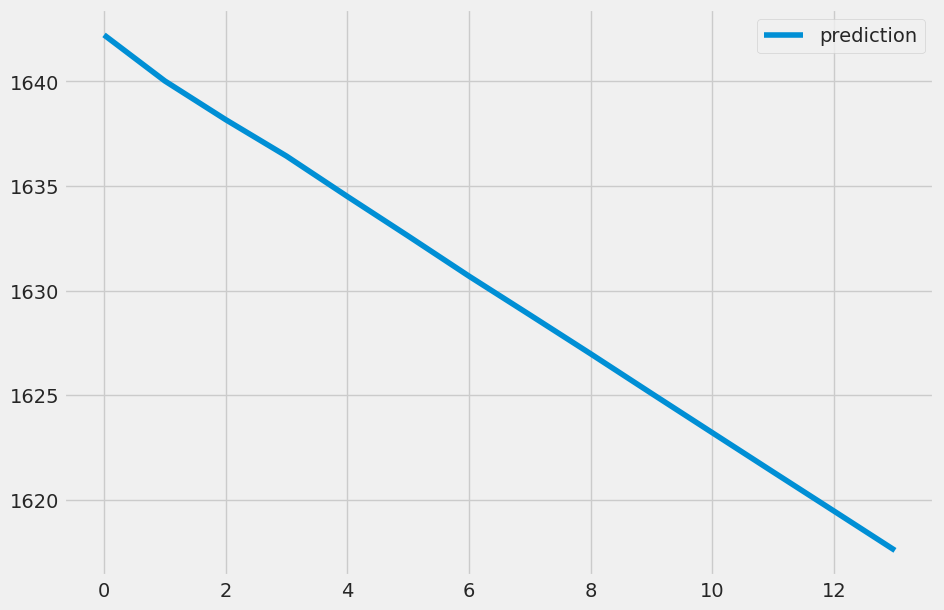

In [62]:
X_train, y_train, X_test, sc = ts_train_test_normalize(df,5,2)
my_R_GRU_model_50, R_GRU_predictions_50 = GRU_model_regularization(X_train, y_train, X_test, sc, 50)
R_GRU_predictions_50[1:10]
actual_pred_plot(R_GRU_predictions_50)
getRMSE(R_GRU_predictions_50)
predFuture(my_R_GRU_model_50)

In [ ]:
my_R_GRU_model_50.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 5, 32)             3360      
                                                                 
 dropout_16 (Dropout)        (None, 5, 32)             0         
                                                                 
 gru_21 (GRU)                (None, 5, 32)             6336      
                                                                 
 dropout_17 (Dropout)        (None, 5, 32)             0         
                                                                 
 gru_22 (GRU)                (None, 5, 32)             6336      
                                                                 
 dropout_18 (Dropout)        (None, 5, 32)             0         
                                                                 
 gru_23 (GRU)                (None, 32)              